In [1]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 33.3 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


Total molecules: 100
Max_Similarity range: 0.2285714285714285 - 0.75


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


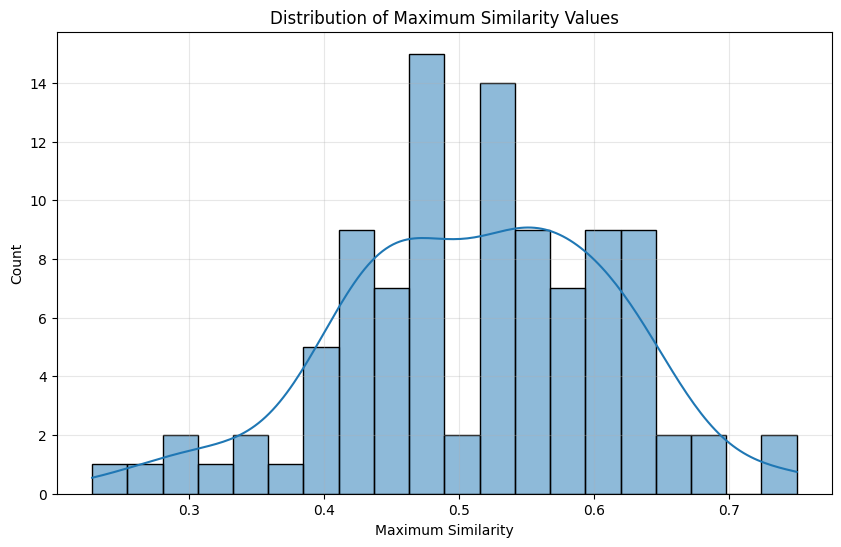

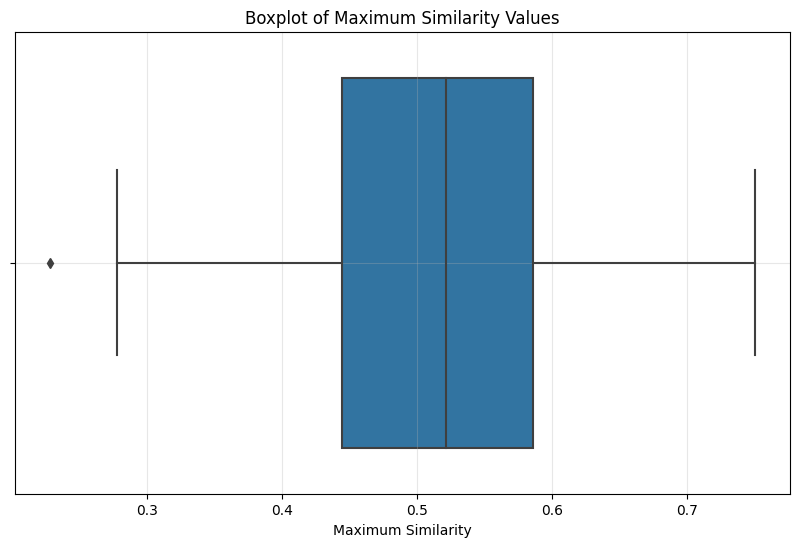

/usr/local/lib/python3.11/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:343: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


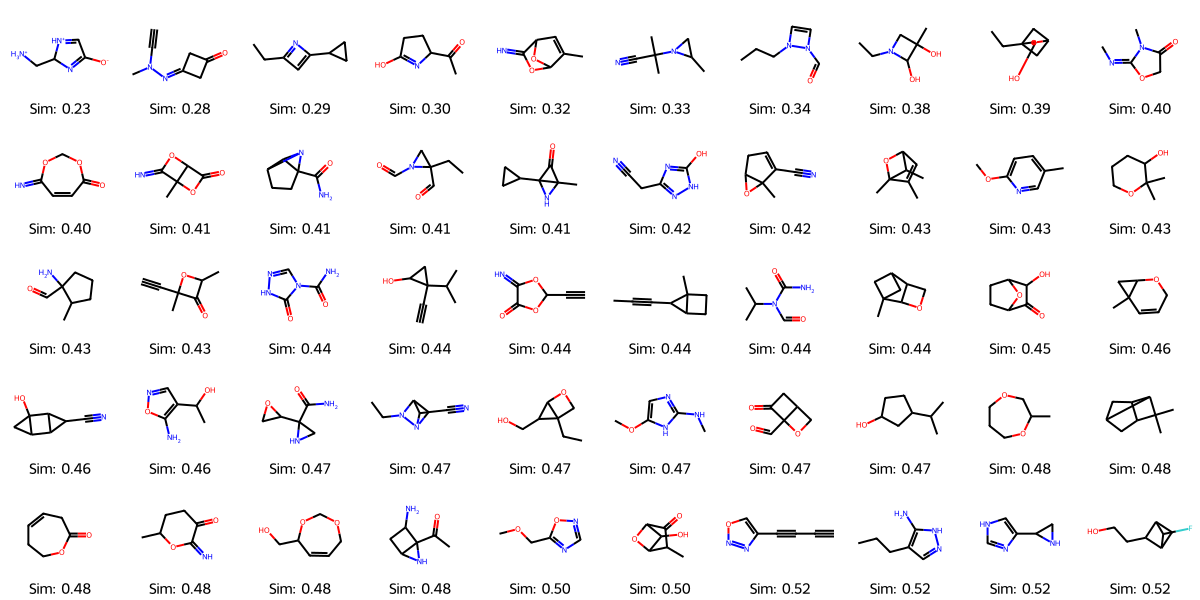

Novel molecules: 100 (100.0%)


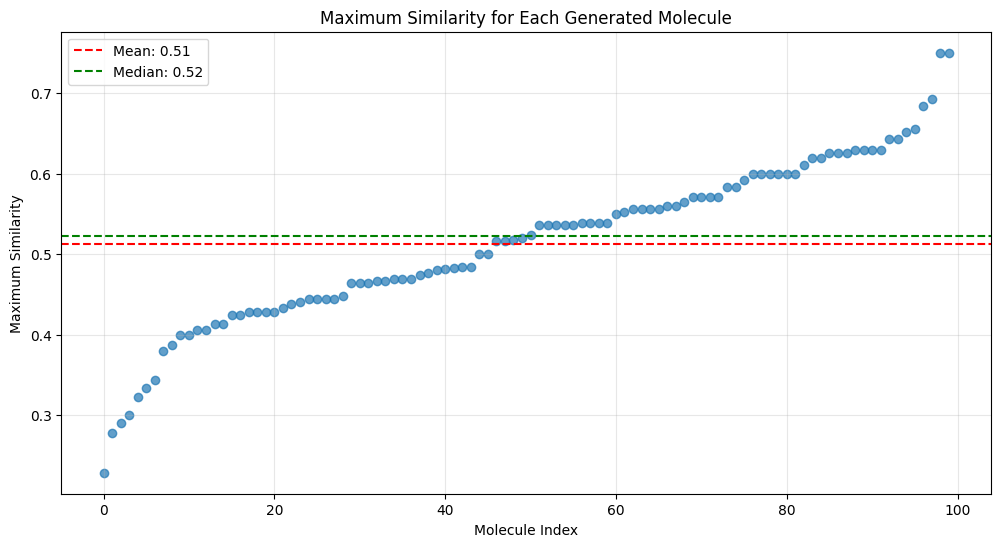


Showing first 20 molecules with similarity scores:


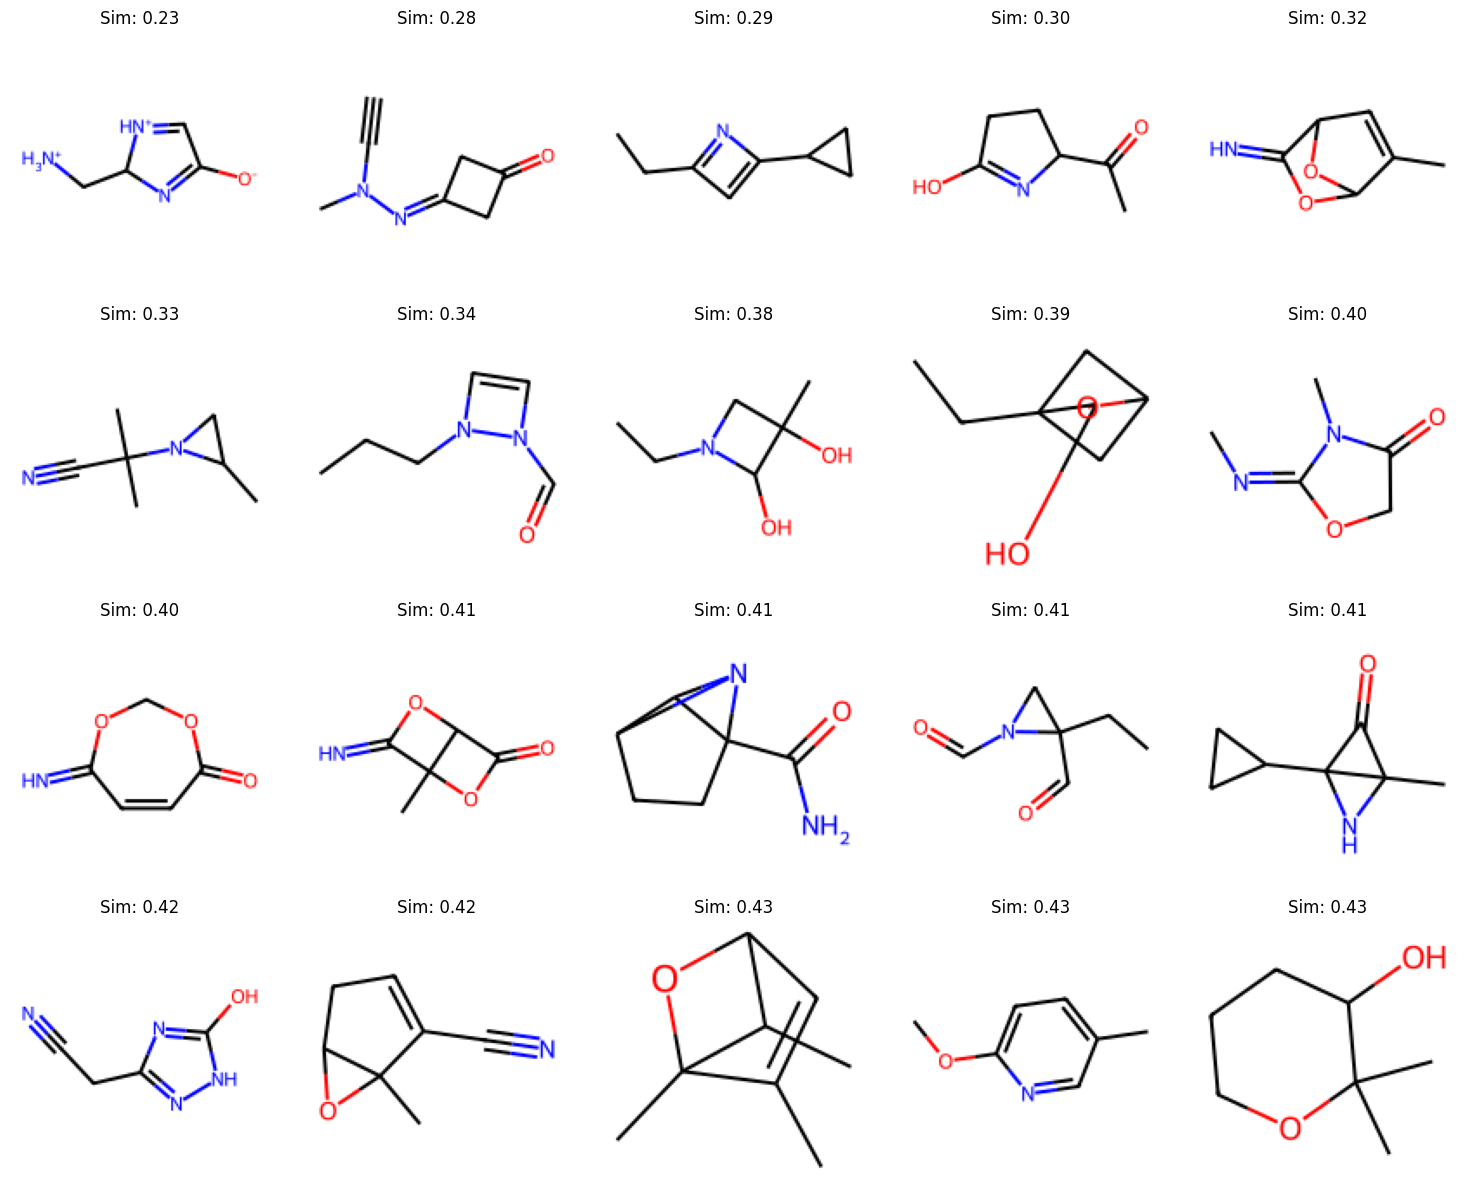


Summary Statistics for Maximum Similarity:
count    100.000000
mean       0.512890
std        0.100963
min        0.228571
25%        0.444444
50%        0.521905
75%        0.585648
max        0.750000
Name: Max_Similarity, dtype: float64

Top 5 Most Novel Molecules (Lowest Similarity):
             Canonical_SMILES  Max_Similarity
0  [NH3+]CC1N=C([O-])C=[NH+]1        0.228571
1         C#CN(C)N=C1CC(=O)C1        0.277778
2           CCC1=NC(C2CC2)=C1        0.290323
3           CC(=O)C1CCC(O)=N1        0.300000
4             CC1=CC2OC1OC2=N        0.322581

Top 5 Least Novel Molecules (Highest Similarity):
     Canonical_SMILES  Max_Similarity
99        CC#CCCC1CO1        0.750000
98        CC1CC12CCO2        0.750000
97  CC(C)C1C=CC(=O)C1        0.692308
96  CC1C2CC(O)C(O)C12        0.684211
95   CCC12COC(=O)C1C2        0.655172


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


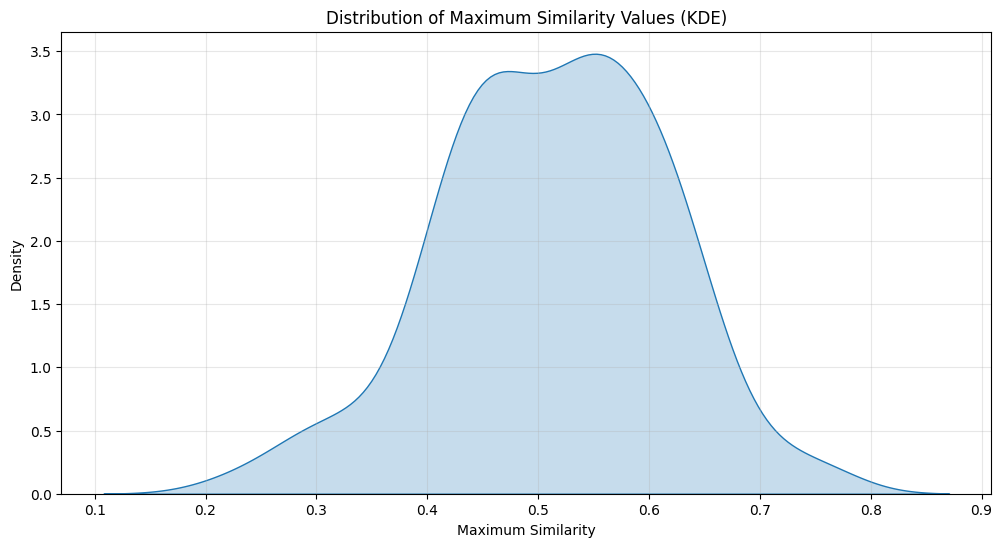

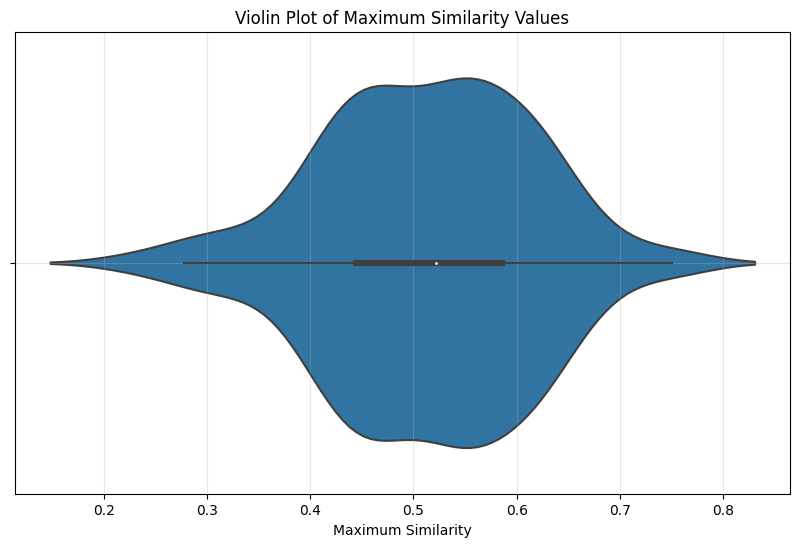

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
import seaborn as sns
from matplotlib.gridspec import GridSpec
import io
from PIL import Image

# Load the data
df = pd.read_csv('/kaggle/input/rnn-generated-smiles/generated_molecules_analysis.csv')

# Check the data
print(f"Total molecules: {len(df)}")
print(f"Max_Similarity range: {df['Max_Similarity'].min()} - {df['Max_Similarity'].max()}")

# Create a histogram of Max_Similarity
plt.figure(figsize=(10, 6))
sns.histplot(df['Max_Similarity'], bins=20, kde=True)
plt.title('Distribution of Maximum Similarity Values')
plt.xlabel('Maximum Similarity')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

# Create a boxplot of Max_Similarity
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Max_Similarity'])
plt.title('Boxplot of Maximum Similarity Values')
plt.xlabel('Maximum Similarity')
plt.grid(True, alpha=0.3)
plt.show()

# Function to create molecule grid
def create_molecule_grid(smiles_list, n_cols=10, n_rows=10, img_size=(120, 120)):
    # Convert SMILES to RDKit molecules
    mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    
    # Filter out None values (invalid SMILES)
    valid_mols = [m for m in mols if m is not None]
    
    if len(valid_mols) < len(smiles_list):
        print(f"Warning: {len(smiles_list) - len(valid_mols)} molecules could not be parsed")
    
    # Create a grid of molecules
    img = Draw.MolsToGridImage(
        valid_mols[:n_rows*n_cols],
        molsPerRow=n_cols,
        subImgSize=img_size,
        legends=[f"Sim: {df['Max_Similarity'].iloc[i]:.2f}" for i in range(len(valid_mols[:n_rows*n_cols]))]
    )
    return img

# Use Canonical SMILES for visualization
molecules_img = create_molecule_grid(df['Canonical_SMILES'].tolist())
# Display the image instead of saving it
display(molecules_img)  # This works in Jupyter environments

# Create a visualization that combines the molecule grid with similarity data
# Group molecules by similarity range
def create_similarity_bins_visualization(df, bin_width=0.1):
    # Create bins
    bins = np.arange(0, 1 + bin_width, bin_width)
    df['Similarity_Bin'] = pd.cut(df['Max_Similarity'], bins)
    
    # Get counts for each bin
    bin_counts = df['Similarity_Bin'].value_counts().sort_index()
    
    # Setup the figure
    fig = plt.figure(figsize=(15, 12))
    gs = GridSpec(2, 1, height_ratios=[1, 3])
    
    # Plot histogram on top
    ax1 = fig.add_subplot(gs[0])
    bin_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
    ax1.bar(bin_centers, bin_counts, width=bin_width*0.8)
    ax1.set_title('Distribution of maximum Similarity Values')
    ax1.set_xlabel('Maximum Similarity')
    ax1.set_ylabel('Count')
    ax1.grid(True, alpha=0.3)
    
    # Select example molecules from each bin (up to 4 per bin)
    example_smiles = []
    example_similarities = []
    
    for bin_name, group in df.groupby('Similarity_Bin'):
        if len(group) > 0:
            # Select up to 4 examples from each bin
            for _, row in group.head(min(4, len(group))).iterrows():
                example_smiles.append(row['Canonical_SMILES'])
                example_similarities.append(row['Max_Similarity'])
    
    # Plot molecule examples below
    ax2 = fig.add_subplot(gs[1])
    ax2.axis('off')
    
    # Convert SMILES to RDKit molecules
    example_mols = [Chem.MolFromSmiles(s) for s in example_smiles]
    valid_mols = [m for i, m in enumerate(example_mols) if m is not None]
    valid_similarities = [example_similarities[i] for i, m in enumerate(example_mols) if m is not None]
    
    # Create a grid image
    img = Draw.MolsToGridImage(
        valid_mols,
        molsPerRow=4,
        subImgSize=(200, 200),
        legends=[f"Sim: {sim:.2f}" for sim in valid_similarities]
    )
    
    # Convert the PIL image to a format matplotlib can display
    ax2.imshow(img)
    ax2.set_title('Example Molecules by Similarity Bin')
    
    plt.tight_layout()
    plt.show()

# Create the binned visualization
#create_similarity_bins_visualization(df)

# Analyze novelty
novel_count = df['Novel'].sum()
print(f"Novel molecules: {novel_count} ({novel_count/len(df)*100:.1f}%)")

# Create a scatter plot showing the relationship between Max_Similarity
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['Max_Similarity'], alpha=0.7)
plt.axhline(y=df['Max_Similarity'].mean(), color='r', linestyle='--', label=f'Mean: {df["Max_Similarity"].mean():.2f}')
plt.axhline(y=df['Max_Similarity'].median(), color='g', linestyle='--', label=f'Median: {df["Max_Similarity"].median():.2f}')
plt.title('Maximum Similarity for Each Generated Molecule')
plt.xlabel('Molecule Index')
plt.ylabel('Maximum Similarity')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Alternative visualization for environments without display support
def display_molecule_grid(smiles_list, n_cols=5, img_size=(150, 150)):
    """Create molecule grid for console environments"""
    # Convert SMILES to RDKit molecules
    mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    valid_mols = [m for m in mols if m is not None]
    
    # Create subplots
    n_mols = len(valid_mols)
    n_rows = (n_mols + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    axes = axes.flatten()
    
    for i, mol in enumerate(valid_mols):
        if i < len(axes):
            img = Draw.MolToImage(mol, size=img_size)
            axes[i].imshow(img)
            axes[i].set_title(f"Sim: {df['Max_Similarity'].iloc[i]:.2f}")
            axes[i].axis('off')
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# If display() doesn't work in your environment, try this alternative
# Display first 20 molecules as an example
print("\nShowing first 20 molecules with similarity scores:")
display_molecule_grid(df['Canonical_SMILES'].head(20).tolist())

# Summary statistics
print("\nSummary Statistics for Maximum Similarity:")
print(df['Max_Similarity'].describe())

# Find molecules with lowest and highest similarity
print("\nTop 5 Most Novel Molecules (Lowest Similarity):")
print(df.sort_values('Max_Similarity').head(5)[['Canonical_SMILES', 'Max_Similarity']])

print("\nTop 5 Least Novel Molecules (Highest Similarity):")
print(df.sort_values('Max_Similarity', ascending=False).head(5)[['Canonical_SMILES', 'Max_Similarity']])

# Create a distribution plot using seaborn
plt.figure(figsize=(12, 6))
sns.kdeplot(df['Max_Similarity'], fill=True)
plt.title('Distribution of Maximum Similarity Values (KDE)')
plt.xlabel('Maximum Similarity')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.show()

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x=df['Max_Similarity'])
plt.title('Violin Plot of Maximum Similarity Values')
plt.xlabel('Maximum Similarity')
plt.grid(True, alpha=0.3)
plt.show()


In [6]:
print(len(set(df['Canonical_SMILES'])))

100
